# ***Assignment 3 for Data Analysis 3***

Conducted by Ian Brandenburg and Zsófia Rebeka Katona

[GitHub Repo](https://github.com/Iandrewburg/DA3_Brandenburg/tree/main/Assignment_3)



Developing a predictive model to identify which small or medium-sized firms in the "Manufacture of computer, electronic, and optical products" industry might fail in 2015, based on their activity in 2014.

[**Data source**](https://osf.io/b2ft9/?view_only=):
Detailed company data from a middle-sized country in the European Union
All registered companies in 2005-2016 in three selected industries 
  (auto manufacturing, equipment manufacturing, hotels and restaurants)
This rich database was constructed for from multiple publicly available sources 
by Bisnode, a business data and anlytics company www.bisnode.com
for educational purposes

Dependent Variable - Dummy Variable for if the company defaulted or not

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import math
import os
from pathlib import Path
import sys
from plotnine import *
from mizani.formatters import percent_format
import ast
from patsy import dmatrices
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import time

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [2]:
# Helper Functions

def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def create_coef_matrix(X, model):
    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns),pd.DataFrame(model.coef_.flatten())], axis = 1
    )
    coef_matrix.columns = ['variable', 'coefficient']
    coef_matrix.iloc[-1] = ['Intercept', model.intercept_.flatten()[0]]
    return coef_matrix

def cv_summary(lambdas, C_values, model):
    d = {'lambdas': lambdas, 'C_values': C_values, 'mean_cv_score': model.scores_[1].mean(axis = 0)}
    return(pd.DataFrame(data=d))

def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    })
    
    plot = ggplot(all_coords, aes(x = 'fpr', y = 'tpr')) \
        + geom_line(color=color[0], size = 0.7) \
        + geom_area(position = 'identity', fill = 'mediumaquamarine', alpha = 0.3) \
        + xlab("False Positive Rate (1-Specifity)") \
        + ylab("True Positive Rate (Sensitivity)") \
        + geom_abline(intercept = 0, slope = 1,  linetype = "dotted", color = "black") \
        + scale_y_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0, 0.01)) \
        + scale_x_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0.01, 0)) \
        + theme_bw()
    return(plot)

def sigmoid_array(x):
    return(1 / (1 + np.exp(-x)))

def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold,param_index,:]
    return(sigmoid_array(np.dot(X, np.transpose(fold_coef)[:-1]) +  np.transpose(fold_coef)[-1]))

def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy['loss'] = (all_coords_copy.false_pos*FP + all_coords_copy.false_neg*FN)/all_coords_copy.n
    
    t = optimal_threshold
    l = curr_exp_loss
    
    plot = ggplot(all_coords_copy, aes(x = 'thresholds', y = 'loss')) + \
        geom_line(color=color[0], size=0.7) + \
        scale_x_continuous(breaks = seq(0, 1.1, by = 0.1)) + \
        coord_cartesian(xlim=(0,1))+ \
        geom_vline(xintercept = t , color = color[0] ) + \
        annotate(geom = "text", x = t - 0.01, y= max(all_coords_copy.loss) - 0.4,
                 label="best threshold: " + str(round(t,2)),
                 colour=color[1], angle=90, size = 7) +\
        annotate(geom = "text", x = t + 0.06, y= l,\
                 label= str(round(l, 2)), size = 7) +\
        theme_bw()
    return(plot)


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy['sp'] = all_coords_copy.true_neg/all_coords_copy.neg
    all_coords_copy['se'] = all_coords_copy.true_pos/all_coords_copy.pos
    
    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = ggplot(all_coords_copy, aes(x = 'sp', y = 'se')) +\
        geom_line(color=color[0], size=0.7) +\
        scale_y_continuous(breaks = seq(0, 1.1, by = 0.1)) +\
        scale_x_reverse(breaks = seq(0, 1.1, by = 0.1)) +\
        geom_point(data = pd.DataFrame({'sp': [sp], 'se': [se]})) +\
        annotate(geom = "text", x = sp, y = se + 0.03,
                 label = str(round(sp, 2)) + ', ' + str(round(se, 2)), size = 7) +\
        theme_bw()
    return(plot)

# ***1. Data Processing***

## 1.1 Import Data Directly from GitHub

In [3]:
data = pd.read_csv('https://github.com/Iandrewburg/DA3_Brandenburg/raw/main/Assignment_3/cs_bisnode_panel.csv')
data.head()

,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,1001034.0,2005-01-01,2005-12-31,NaN,692.592590,7266.666504,7574.074219,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
1,1001034.0,2006-01-01,2006-12-31,NaN,603.703674,13122.222656,12211.111328,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
2,1001034.0,2007-01-01,2007-12-31,NaN,425.925934,8196.295898,7800.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
3,1001034.0,2008-01-01,2008-12-31,NaN,300.000000,8485.185547,7781.481445,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
4,1001034.0,2009-01-01,2009-12-31,NaN,207.407410,5137.037109,15300.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,0.083333


In [4]:
data

,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,1.001034e+06,2005-01-01,2005-12-31,NaN,692.592590,7266.666504,7574.074219,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
1,1.001034e+06,2006-01-01,2006-12-31,NaN,603.703674,13122.222656,12211.111328,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
2,1.001034e+06,2007-01-01,2007-12-31,NaN,425.925934,8196.295898,7800.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
3,1.001034e+06,2008-01-01,2008-12-31,NaN,300.000000,8485.185547,7781.481445,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
4,1.001034e+06,2009-01-01,2009-12-31,NaN,207.407410,5137.037109,15300.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287824,4.641209e+11,2011-01-01,2011-12-31,NaN,0.000000,1807.407349,3.703704,0.0,0.0,0.0,...,female,Domestic,5510.0,55.0,3.0,2,East,1990-08-22,NaN,NaN
287825,4.641209e+11,2012-01-01,2012-12-31,NaN,0.000000,1518.518555,96.296295,0.0,0.0,0.0,...,female,Domestic,5510.0,55.0,3.0,2,East,1990-08-22,NaN,NaN
287826,4.641209e+11,2013-01-01,2013-12-31,NaN,0.000000,988.888916,77.777779,0.0,0.0,0.0,...,NaN,NaN,5510.0,55.0,3.0,2,East,1990-08-22,NaN,NaN
287827,4.641209e+11,2014-01-01,2014-12-31,NaN,0.000000,644.444458,233.333328,0.0,0.0,0.0,...,female,Domestic,5510.0,55.0,3.0,2,East,1990-08-22,NaN,NaN


In [5]:
# Checking out the column names
data.columns

Index(['comp_id', 'begin', 'end', 'COGS', 'amort', 'curr_assets', 'curr_liab',
       'extra_exp', 'extra_inc', 'extra_profit_loss', 'finished_prod',
       'fixed_assets', 'inc_bef_tax', 'intang_assets', 'inventories',
       'liq_assets', 'material_exp', 'net_dom_sales', 'net_exp_sales',
       'personnel_exp', 'profit_loss_year', 'sales', 'share_eq',
       'subscribed_cap', 'tang_assets', 'wages', 'D', 'balsheet_flag',
       'balsheet_length', 'balsheet_notfullyear', 'year', 'founded_year',
       'exit_year', 'ceo_count', 'foreign', 'female', 'birth_year',
       'inoffice_days', 'gender', 'origin', 'nace_main', 'ind2', 'ind',
       'urban_m', 'region_m', 'founded_date', 'exit_date', 'labor_avg'],
      dtype='object')

In [6]:
# Checking out the info of the data set
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287829 entries, 0 to 287828
Data columns (total 48 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   comp_id               287829 non-null  float64
 1   begin                 287829 non-null  object 
 2   end                   287829 non-null  object 
 3   COGS                  18257 non-null   float64
 4   amort                 279789 non-null  float64
 5   curr_assets           287698 non-null  float64
 6   curr_liab             287698 non-null  float64
 7   extra_exp             269300 non-null  float64
 8   extra_inc             269300 non-null  float64
 9   extra_profit_loss     270626 non-null  float64
 10  finished_prod         17485 non-null   float64
 11  fixed_assets          287698 non-null  float64
 12  inc_bef_tax           280392 non-null  float64
 13  intang_assets         287689 non-null  float64
 14  inventories           287698 non-null  float64
 15  

## 1.2 Hold Out Sample

In [7]:
data = (
    data.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
data = data.replace("toReplace", np.nan)  # only way I could define it as NaN
# generate status_alive; if sales larger than zero and not-NA, then firm is alive
data["status_alive"] = (data["sales"] > 0 & (False == data["sales"].isna())).astype(int)

# defaults in two years if there are sales in this year but no sales two years later
# Status_in_two_years: data.groupby('comp_id')['status_alive'].shift(-2)
data["default"] = (
    (data["status_alive"] == 1)
    & (data.groupby("comp_id")["status_alive"].shift(-1) == 0)
).astype(int)


In [8]:
hold_out_sample = data[(data['ind2'] == 26) &
                     (data['sales'] >= 1000) &
                     (data['sales'] <= 10000000) &
                     (data['year'] == 2014)]
hold_out_sample

,year,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,...,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg,status_alive,default
417864,2014,6.538183e+06,2014-01-01,2014-12-31,NaN,1018.518494,17022.222656,3040.740723,0.0,0.0,...,2630.0,26.0,2.0,2.0,East,1992-08-25,NaN,NaN,1,0
417890,2014,8.416055e+06,2014-01-01,2014-12-31,NaN,425.925934,105740.742188,6918.518555,0.0,0.0,...,2651.0,26.0,2.0,1.0,Central,1995-08-28,NaN,0.083333,1,0
417942,2014,1.242838e+07,2014-01-01,2014-12-31,NaN,0.000000,0.000000,9277.777344,0.0,0.0,...,2660.0,26.0,2.0,2.0,Central,1991-06-27,NaN,0.083333,1,0
417989,2014,1.777654e+07,2014-01-01,2014-12-31,NaN,48.148148,142296.296875,164237.031250,0.0,0.0,...,2620.0,26.0,2.0,1.0,Central,1997-07-01,NaN,0.305556,1,0
417994,2014,1.862676e+07,2014-01-01,2014-12-31,NaN,5755.555664,95185.187500,45766.667969,0.0,0.0,...,2670.0,26.0,2.0,2.0,West,2010-11-15,NaN,0.159091,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463875,2014,4.593723e+11,2014-01-01,2014-12-31,NaN,0.000000,40740.742188,559.259277,0.0,0.0,...,2620.0,26.0,2.0,2.0,East,1993-08-06,NaN,0.083333,1,0
463965,2014,4.610112e+11,2014-01-01,2014-12-31,NaN,429.629639,58781.480469,2651.851807,0.0,0.0,...,2620.0,26.0,2.0,3.0,Central,1997-12-10,NaN,0.166667,1,0
464018,2014,4.620594e+11,2014-01-01,2014-12-31,NaN,1111.111084,68274.070312,16211.111328,0.0,0.0,...,2630.0,26.0,2.0,1.0,Central,1996-12-30,NaN,0.250000,1,0
464032,2014,4.623300e+11,2014-01-01,2014-12-31,NaN,0.000000,17192.591797,7325.925781,0.0,0.0,...,2611.0,26.0,2.0,2.0,East,2010-12-15,NaN,0.166667,1,0


In [9]:
print("MISSING VALUES FROM HOLDOUT SAMPLE")
print("-"*35)
to_filter = hold_out_sample.isnull().sum()
to_filter[to_filter > 0]

MISSING VALUES FROM HOLDOUT SAMPLE
-----------------------------------


COGS              948
amort               2
finished_prod     950
material_exp        2
net_dom_sales     948
net_exp_sales     948
personnel_exp       2
wages             949
D                1037
founded_year       31
exit_year        1014
ceo_count          31
foreign            31
female             31
birth_year        114
inoffice_days      31
gender             31
origin             31
region_m            2
exit_date        1012
labor_avg         312
dtype: int64

#### Hold Out Sample Summary Table

In [10]:
hold_out_summary = {
    'Number of Firms': [hold_out_sample.shape[0]],
    'Mean Sales': [hold_out_sample['sales'].mean()],
    'Min Sales': [hold_out_sample['sales'].min()],
    'Max Sales': [hold_out_sample['sales'].max()],
    'Defaulted Firms': [hold_out_sample['default'].sum()],
    'Stayed Alive Firms': [(hold_out_sample['default'] == 0).sum()]

}

hold_out_summary_df = pd.DataFrame(hold_out_summary)
hold_out_summary_df

,Number of Firms,Mean Sales,Min Sales,Max Sales,Defaulted Firms,Stayed Alive Firms
0,1037,490202.217927,1070.370361,9576485.0,56,981


## 1.3 Data Cleaning

Missing values for a specific year (2014) and the entire dataset will be compared. 

In [11]:
# Filtering and creating a separate data set for 2014 data
data_2014 = data[(data['ind2'] == 26) &
                     (data['year'] == 2014)]
data_2014

,year,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,...,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg,status_alive,default
417864,2014,6.538183e+06,2014-01-01,2014-12-31,NaN,1018.518494,17022.222656,3040.740723,0.0,0.0,...,2630.0,26.0,2.0,2.0,East,1992-08-25,NaN,NaN,1,0
417890,2014,8.416055e+06,2014-01-01,2014-12-31,NaN,425.925934,105740.742188,6918.518555,0.0,0.0,...,2651.0,26.0,2.0,1.0,Central,1995-08-28,NaN,0.083333,1,0
417922,2014,1.089394e+07,2014-07-24,2014-12-31,NaN,0.000000,30614.814453,128055.546875,0.0,0.0,...,2651.0,26.0,2.0,1.0,Central,2004-12-13,NaN,NaN,0,0
417942,2014,1.242838e+07,2014-01-01,2014-12-31,NaN,0.000000,0.000000,9277.777344,0.0,0.0,...,2660.0,26.0,2.0,2.0,Central,1991-06-27,NaN,0.083333,1,0
417969,2014,1.571155e+07,2014-01-01,2014-12-31,NaN,0.000000,2477.777832,0.000000,0.0,0.0,...,2630.0,26.0,2.0,1.0,Central,2001-09-01,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463940,2014,4.604901e+11,2014-01-01,2014-12-31,NaN,0.000000,33.333332,585.185181,0.0,0.0,...,2640.0,26.0,2.0,2.0,East,2000-06-14,NaN,NaN,0,0
463965,2014,4.610112e+11,2014-01-01,2014-12-31,NaN,429.629639,58781.480469,2651.851807,0.0,0.0,...,2620.0,26.0,2.0,3.0,Central,1997-12-10,NaN,0.166667,1,0
464018,2014,4.620594e+11,2014-01-01,2014-12-31,NaN,1111.111084,68274.070312,16211.111328,0.0,0.0,...,2630.0,26.0,2.0,1.0,Central,1996-12-30,NaN,0.250000,1,0
464032,2014,4.623300e+11,2014-01-01,2014-12-31,NaN,0.000000,17192.591797,7325.925781,0.0,0.0,...,2611.0,26.0,2.0,2.0,East,2010-12-15,NaN,0.166667,1,0


In [12]:
# Comparing the missing values from the entire data set and data from 2014
print("MISSING VALUES FROM ENTIRE DATASET")
print("-"*35)
to_filter = data.isnull().sum()
to_filter[to_filter > 0]

MISSING VALUES FROM ENTIRE DATASET
-----------------------------------


begin                   269115
end                     269115
COGS                    538687
amort                   277155
curr_assets             269246
curr_liab               269246
extra_exp               287644
extra_inc               287644
extra_profit_loss       286318
finished_prod           539459
fixed_assets            269246
inc_bef_tax             276552
intang_assets           269255
inventories             269246
liq_assets              269246
material_exp            277155
net_dom_sales           538687
net_exp_sales           538687
personnel_exp           277155
profit_loss_year        278999
sales                   276552
share_eq                269246
subscribed_cap          269246
tang_assets             270585
wages                   538961
D                       556944
balsheet_flag           269115
balsheet_length         269115
balsheet_notfullyear    269115
founded_year            325572
exit_year               518085
ceo_count               325542
foreign 

After reviewing the null values, `COGS`, `finished_production`, `net_dom_sale`, `net_exp_sales`, and `wages` will most likely need to be dropped. 

The null values will need to be viewed for one specific year to get an understanding of null values where the company only iterates once in the dataframe.
This way the null values can be better interpreted. 

In [13]:
data_2014.isnull().sum()
print("MISSING VALUES FROM 2014 DATASET")
print("-"*33)
to_filter = data_2014.isnull().sum()
to_filter[to_filter > 0]

MISSING VALUES FROM 2014 DATASET
---------------------------------


COGS                 1176
amort                   5
extra_exp               1
extra_inc               1
extra_profit_loss       1
finished_prod        1178
inc_bef_tax             1
material_exp            5
net_dom_sales        1176
net_exp_sales        1176
personnel_exp           5
sales                   1
wages                1179
D                    1317
founded_year           58
exit_year            1276
ceo_count              58
foreign                58
female                 58
birth_year            210
inoffice_days          58
gender                 58
origin                 58
region_m                3
exit_date            1268
labor_avg             521
dtype: int64

Here, we can verify that `COGS`, `finished_prod`, `net_dom_sale`, `net_exp_sales`, and `wages` will need to be dropped from the analysis. 

`exit_year` and `exit date` can stay since not all companies are exiting, and we are trying to predict how many companies will exit.

The `D` column will also be dropped for it's high frequency of missing values

Also dropping `ind` column, as it does not serve any use in this specific project.

With `labor_avg` having such a high number of missing values, this column will also be dropped.

In [14]:
# Dropping the columns with too many missing values in the original data
data = data.drop(columns = ['COGS',
                            'finished_prod',
                            'net_dom_sales',
                            'net_exp_sales',
                            'wages',
                            'D',
                            'ind',
                            'labor_avg'])

In [15]:
to_filter = data.isnull().sum()
to_filter[to_filter > 0]

begin                   269115
end                     269115
amort                   277155
curr_assets             269246
curr_liab               269246
extra_exp               287644
extra_inc               287644
extra_profit_loss       286318
fixed_assets            269246
inc_bef_tax             276552
intang_assets           269255
inventories             269246
liq_assets              269246
material_exp            277155
personnel_exp           277155
profit_loss_year        278999
sales                   276552
share_eq                269246
subscribed_cap          269246
tang_assets             270585
balsheet_flag           269115
balsheet_length         269115
balsheet_notfullyear    269115
founded_year            325572
exit_year               518085
ceo_count               325542
foreign                 325542
female                  325542
birth_year              380933
inoffice_days           325542
gender                  325542
origin                  325542
nace_mai

In [16]:
# Dropping the columns with too many missing values from the 2014 data
data_2014 = data_2014.drop(columns = ['COGS',
                                      'finished_prod',
                                      'net_dom_sales',
                                      'net_exp_sales',
                                      'wages',
                                      'D',
                                      'ind',
                                      'labor_avg'])

In [17]:
to_filter_2014 = data_2014.isnull().sum()
to_filter_2014[to_filter_2014 > 0]

amort                   5
extra_exp               1
extra_inc               1
extra_profit_loss       1
inc_bef_tax             1
material_exp            5
personnel_exp           5
sales                   1
founded_year           58
exit_year            1276
ceo_count              58
foreign                58
female                 58
birth_year            210
inoffice_days          58
gender                 58
origin                 58
region_m                3
exit_date            1268
dtype: int64

In [18]:
# Creating a function to handle missing values

def data_dish_washer(data):
    # Step 1: Imputing with 0: Fill specific columns with 0 in case of numerical values
    zero_fill_cols = ['amort',
                      'curr_assets',
                      'personnel_exp', 
                      'material_exp',
                      'liq_assets',
                      'inventories',
                      'intang_assets', 
                      'fixed_assets',
                      'extra_profit_loss',
                      'extra_inc',
                      'extra_exp', 
                      'curr_liab',
                      'tang_assets']
    data[zero_fill_cols] = data[zero_fill_cols].fillna(0)


    # Step 2: Imputing with median: Fill missing values with median where it makes sense
    median_fill_cols = ['sales',
                        'profit_loss_year',
                        'inc_bef_tax', 
                        'share_eq',
                        'subscribed_cap']
    for col in median_fill_cols:
        data[col] = data[col].fillna(data[col].median())

    # Step 3: Change: Drop rows with missing values in specified categorical columns
    row_drops = ['nace_main',
                 'ind2',
                 'ceo_count', 
                 'foreign', 
                 'female',
                 'inoffice_days',
                 'gender',
                 'origin']
    data = data.dropna(subset=row_drops)

    # Step 4: Fill missing regions with 'NaN'
    data['region_m'] = data['region_m'].fillna('NaN')

    # Step 5: Convert Date variables to datetime types
    datetime_columns = ['begin',
                        'end',
                        'founded_date',
                        'exit_date']
    for col in datetime_columns:
        data[col] = pd.to_datetime(data[col], errors='coerce')

    # Step 6: Verify Numeric Columns
    numeric_columns = ['year',
                       'founded_year',
                       'exit_year',
                       'birth_year']
    for col in numeric_columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    

    return data

In [19]:
# Transforming the Infinite values with NaNs in data
data = data.replace([np.inf, -np.inf], np.nan)

In [20]:
# Transforming the Infinite values with NaNs in data 2014
data_2014 = data_2014.replace([np.inf, -np.inf], np.nan)

In [21]:
data = data_dish_washer(data)
data

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,gender,origin,nace_main,ind2,urban_m,region_m,founded_date,exit_date,status_alive,default
0,2005,1.001034e+06,2005-01-01,2005-12-31,692.592590,7.266667e+03,7574.074219,0.0,0.000000,0.000000,...,mix,Domestic,5630.0,56.0,1.0,Central,1990-11-19,NaT,1,0
4,2005,1.004012e+06,2005-01-01,2005-12-31,114.814812,1.648148e+03,3777.777832,0.0,0.000000,0.000000,...,male,Domestic,3314.0,33.0,3.0,West,1991-11-24,2013-06-19,1,0
7,2005,1.011889e+06,2005-01-01,2005-12-31,51625.925781,3.500370e+04,4988.888672,0.0,31925.925781,31925.925781,...,male,Domestic,5510.0,55.0,2.0,West,1992-11-09,NaT,1,0
8,2005,1.014183e+06,2005-01-01,2005-12-31,12692.592773,7.918889e+04,2777.777832,0.0,1481.481445,1481.481445,...,female,Domestic,5510.0,55.0,2.0,Central,2001-12-21,NaT,1,0
10,2005,1.022796e+06,2005-01-01,2005-12-31,870.370361,2.073333e+04,4840.740723,0.0,2500.000000,2500.000000,...,male,Domestic,5630.0,56.0,1.0,Central,2001-02-01,2016-06-06,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556924,2016,4.637275e+11,2016-01-01,2016-12-31,1192.592651,2.458889e+04,4955.555664,0.0,0.000000,0.000000,...,male,Domestic,5630.0,56.0,2.0,East,2011-08-27,NaT,1,0
556933,2016,4.638854e+11,2016-01-01,2016-12-31,8992.592773,1.169481e+05,88085.187500,0.0,0.000000,0.000000,...,male,Domestic,4331.0,43.0,3.0,East,2009-02-25,NaT,1,0
556936,2016,4.639820e+11,2016-01-01,2016-12-31,9900.000000,7.580000e+04,85855.554688,0.0,0.000000,0.000000,...,male,Domestic,2822.0,28.0,1.0,Central,1995-05-14,NaT,1,0
556939,2016,4.640446e+11,2016-01-01,2016-12-31,78862.960938,5.597182e+06,793370.375000,0.0,0.000000,0.000000,...,male,Foreign,3312.0,33.0,3.0,Central,2008-10-09,NaT,1,0


In [22]:
to_filter = data.isnull().sum()
to_filter[to_filter > 0]

founded_year        21
exit_year       192543
birth_year       54947
founded_date        21
exit_date       192543
dtype: int64

In [23]:
data.isnull().sum().sum()

440075

In [24]:
data.columns

Index(['year', 'comp_id', 'begin', 'end', 'amort', 'curr_assets', 'curr_liab',
       'extra_exp', 'extra_inc', 'extra_profit_loss', 'fixed_assets',
       'inc_bef_tax', 'intang_assets', 'inventories', 'liq_assets',
       'material_exp', 'personnel_exp', 'profit_loss_year', 'sales',
       'share_eq', 'subscribed_cap', 'tang_assets', 'balsheet_flag',
       'balsheet_length', 'balsheet_notfullyear', 'founded_year', 'exit_year',
       'ceo_count', 'foreign', 'female', 'birth_year', 'inoffice_days',
       'gender', 'origin', 'nace_main', 'ind2', 'urban_m', 'region_m',
       'founded_date', 'exit_date', 'status_alive', 'default'],
      dtype='object')

In [25]:
data.dtypes

year                             int64
comp_id                        float64
begin                   datetime64[ns]
end                     datetime64[ns]
amort                          float64
curr_assets                    float64
curr_liab                      float64
extra_exp                      float64
extra_inc                      float64
extra_profit_loss              float64
fixed_assets                   float64
inc_bef_tax                    float64
intang_assets                  float64
inventories                    float64
liq_assets                     float64
material_exp                   float64
personnel_exp                  float64
profit_loss_year               float64
sales                          float64
share_eq                       float64
subscribed_cap                 float64
tang_assets                    float64
balsheet_flag                  float64
balsheet_length                float64
balsheet_notfullyear           float64
founded_year             

In [26]:
# data['sales_log']

In [27]:
data['sales'].describe()

count    2.308340e+05
mean     4.862897e+05
std      3.813111e+06
min     -2.553889e+05
25%      6.670371e+03
50%      3.316296e+04
75%      1.225519e+05
max      1.110294e+08
Name: sales, dtype: float64

In [28]:
# Custom function to format the describe output
def format_describe(describe_dict):

    formatted_describe = {k: '{:,.2f}'.format(v) for k, v in describe_dict.items()}
    return formatted_describe

# Format the mock describe data
formatted_sales_describe = format_describe(data['sales'].describe())
formatted_sales_describe

{'count': '230,834.00',
 'mean': '486,289.70',
 'std': '3,813,111.24',
 'min': '-255,388.89',
 '25%': '6,670.37',
 '50%': '33,162.96',
 '75%': '122,551.85',
 'max': '111,029,448.00'}

*QUESTION: Why negative sales? What does that mean?*

<Axes: >

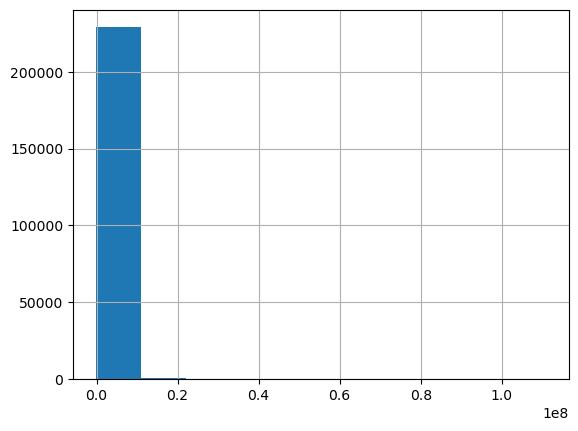

In [29]:
data.sales.hist()

With such a large range, the sales are getting automatically transformed in an unreadable way for visualizations.

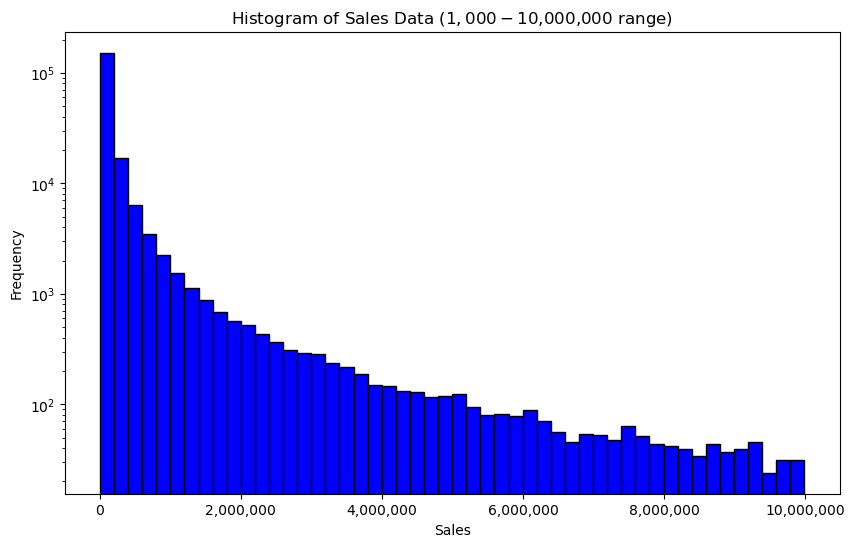

In [30]:
# Filter the data to include only sales within the specified range
filtered_sales = data['sales'][(data['sales'] >= 1000) & (data['sales'] <= 10000000)]

plt.figure(figsize=(10, 6))
plt.hist(filtered_sales, bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Sales Data ($1,000 - $10,000,000 range)')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.yscale('log')  # Log scale for better visualization

# Set x-axis to show actual values with custom formatting
plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.show()


Fitting the sales in a range gives it a much more readable view. There is a huge skew of data, so log trasformation is appropriate.

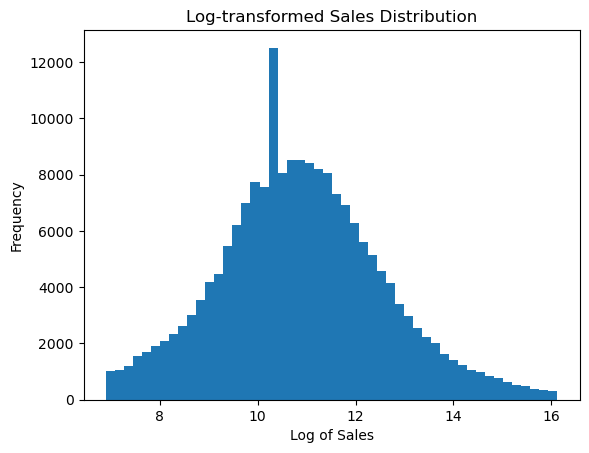

In [31]:
# Apply log transformation to sales data
data['sales_log'] = np.log1p(filtered_sales)
plt.hist(data['sales_log'], bins=50)
plt.xlabel('Log of Sales')
plt.ylabel('Frequency')
plt.title('Log-transformed Sales Distribution')
plt.show()


## 1.4 Label Engineering

In [32]:
# Set the index to the columns of interest
data = data.set_index(["year", "comp_id"])

# Perform the unstack operation, which will automatically introduce NaNs for missing combinations
data = data.unstack().stack(dropna=False)

# Reset the index to make 'year' and 'comp_id' regular columns again
data = data.reset_index()

# Note: The unstack() and stack(dropna=False) operations introduce NaNs for missing entries automatically.


In [33]:
# Generate status_alive; if sales are larger than zero and not-NA, then firm is alive
data["status_alive"] = (data["sales"] > 0 & (False == data["sales"].isna())).astype(int)


# It defaults in two years if there are sales in this year but no sales two years later
# Status_in_two_years: data.groupby('comp_id')['status_alive'].shift(-2)
data["default"] = (
    (data["status_alive"] == 1)
    & (data.groupby("comp_id")["status_alive"].shift(-2) == 0)
).astype(int)


In [34]:
data['status_alive'].value_counts()

status_alive
0    302966
1    199102
Name: count, dtype: int64

In [35]:
data['default'].value_counts()

default
0    457034
1     45034
Name: count, dtype: int64

In [36]:
data['default'].describe()

count    502068.000000
mean          0.089697
std           0.285747
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: default, dtype: float64

This concludes that 311,016 firms defaulted and 245,928 firms stayed alive, and 2 years later, 274,393 will stay alive and 13,436 firms will default.

In [37]:
data['sales'].describe()

count    2.308340e+05
mean     4.862897e+05
std      3.813111e+06
min     -2.553889e+05
25%      6.670371e+03
50%      3.316296e+04
75%      1.225519e+05
max      1.110294e+08
Name: sales, dtype: float64

In [38]:
# Replacimg negative sales values with 1. This operation is done outside of 
# ...the `assign` method because it's a direct modification of the dataframe.
data["sales"] = np.where(
    data["sales"] < 0, 1, data["sales"]
)

# Adding new columns to the dataframe through the `assign` method.
data = data.assign(
    # Create a new column 'ln_sales'. If sales are greater than 0, calculate the natural logarithm of sales.
    # If sales are NaN, keep them as NaN. Otherwise, set to 0. This ensures that negative sales, 
    # ...if any existed before the first operation, now converted to 1, won't result in a math error.
    ln_sales=np.where(
        data["sales"] > 0,
        np.log(data["sales"]),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
    # Convert sales to millions by dividing by 1,000,000 for easier readability and analysis.
    sales_mil=data["sales"] / 1000000,
    # Similar to 'ln_sales', but this time applying the logarithm to the sales converted to millions. 
    # ...Handles NaN and non-positive values similarly.
    sales_mil_log=np.where(
        data["sales"] > 0,
        np.log(data["sales"] / 1000000),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
)

In [39]:
# Calculating the year-over-year change in the logarithm of sales (in millions) by subtracting 
# ...the previous year's value from the current year's value for each company.
data['d1_sales_mil_log']=data['sales_mil_log']-data.groupby('comp_id')['sales_mil_log'].shift(1)


In [40]:
# Calculating the age of each company by subtracting the founding year from the current year. 
# ...If the result is negative (which might happen due to data errors), set the age to 0.
data["age"] = np.where(
    data["year"] - data["founded_year"] < 0, 0, data["year"] - data["founded_year"]
)

# Identifying new companies or those without a full year of balance sheet data. 
# ...Mark them with a 1, others with a 0. If 'age' is NaN, keep it as NaN.
data["new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)),
)

# For new companies, set the year-over-year change in log sales to 0. 
# ...This adjustment is for handling new entries or missing data appropriately.
data["d1_sales_mil_log"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["d1_sales_mil_log"])
)

# If the year-over-year change in log sales is NaN, consider the company 
# ...as new and update the 'new' column accordingly.
data["new"] = np.where(data["d1_sales_mil_log"].isna(), 1, data["new"])

# Replacing NaN values in 'd1_sales_mil_log' with 0, ensuring the dataset 
# ...does not have missing values in this calculation.
data["d1_sales_mil_log"] = np.where(
    data["d1_sales_mil_log"].isna(), 0, data["d1_sales_mil_log"]
)

In [41]:
data['new'].describe()

count    502068.000000
mean          0.657861
std           0.474426
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: new, dtype: float64

This concludes that there are 556,944 new firms.

In [42]:
data.isna().sum()

year                         0
comp_id                      0
begin                   271234
end                     271234
amort                   271234
curr_assets             271234
curr_liab               271234
extra_exp               271234
extra_inc               271234
extra_profit_loss       271234
fixed_assets            271234
inc_bef_tax             271234
intang_assets           271234
inventories             271234
liq_assets              271234
material_exp            271234
personnel_exp           271234
profit_loss_year        271234
sales                   271234
share_eq                271234
subscribed_cap          271234
tang_assets             271234
balsheet_flag           271234
balsheet_length         271234
balsheet_notfullyear    271234
founded_year            271255
exit_year               463777
ceo_count               271234
foreign                 271234
female                  271234
birth_year              326181
inoffice_days           271234
gender  

## 1.5 Sample Design


In [43]:
# Looking at cross section data
data = data.query("year==2014 & status_alive == 1")
# Looking at firms with revenues above 1000 EUR and below 10 million EUR
data = data.query("sales_mil<=10 & sales_mil>=0.001")

## 1.6 Feature Engineering

In [44]:
# Categorizing the industry codes into broader groups
data["ind2_cat"] = data["ind2"].copy()
data["ind2_cat"] = np.where(data["ind2"] > 56, 60, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"] < 26, 20, data["ind2_cat"])
data["ind2_cat"] = np.where(
    (data["ind2"] < 55) & (data["ind2"] > 35), 40, data["ind2_cat"]
)
data["ind2_cat"] = np.where(data["ind2"] == 31, 30, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"].isna(), 99, data["ind2_cat"])

In [45]:
# Checking out the industry codes using comp_id as a reference
data.groupby('ind2_cat').count()['comp_id']

ind2_cat
20.0       50
26.0     1007
27.0      613
28.0     1835
29.0      263
30.0      164
32.0      121
33.0     1892
35.0        1
40.0      196
55.0     2241
56.0    11642
60.0      230
Name: comp_id, dtype: int64

In [46]:
# Adding more variables as firm characteristics
data["age2"] = data["age"] ** 2

# Grouping values for foreign_management as dummies 
data["foreign_management"] = np.where(
    data["foreign"] >= 0.5, 1, np.where(data["foreign"].isna(), np.nan, 0)
)

# Creating new columns for the categorical gender and and region variables
data["gender_m"] = data["gender"].astype("category")
data["m_region_loc"] = data["region_m"].astype("category")

### Looking at financial variables and creating additional ones

In [47]:
# Looking at financial variables and creating new financial ratios

# As assets cannot be negative: transforming the negative asset values to 0 and flagging them
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"] < 0)
        | (data["curr_assets"] < 0)
        | (data["fixed_assets"] < 0)
    ),
    1,
    0,
)
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"].isna())
        | (data["curr_assets"].isna())
        | (data["fixed_assets"].isna())
    ),
    np.nan,
    data["flag_asset_problem"],
)
data.groupby("flag_asset_problem").count()["comp_id"]

flag_asset_problem
0.0    20248
1.0        7
Name: comp_id, dtype: int64

In [48]:
# Tranforming the negative asset variables to 0
data["intang_assets"] = np.where(data["intang_assets"] < 0, 0, data["intang_assets"])
data["curr_assets"] = np.where(data["curr_assets"] < 0, 0, data["curr_assets"])
data["fixed_assets"] = np.where(data["fixed_assets"] < 0, 0, data["fixed_assets"])

In [49]:
# Generating the total assets balance sheet variable by adding up the intangible, current and fixed assets
data["total_assets_bs"] = (
    data["intang_assets"] + data["curr_assets"] + data["fixed_assets"]
)
data["total_assets_bs"].describe()

count    2.025500e+04
mean     2.990882e+05
std      2.925404e+06
min      0.000000e+00
25%      8.994445e+03
50%      3.094815e+04
75%      1.187130e+05
max      3.190691e+08
Name: total_assets_bs, dtype: float64

In [50]:
# Collecting the profit and loss names
pl_names = ['extra_exp',
            'extra_inc',
            'extra_profit_loss',
            'inc_bef_tax',
            'inventories',
            'material_exp',
            'profit_loss_year',
            'personnel_exp']
# Collecting the balance sheet names
bs_names = ['intang_assets',
            'curr_liab',
            'fixed_assets',
            'liq_assets',
            'curr_assets',
            'share_eq',
            'subscribed_cap',
            'tang_assets' ]

In [51]:
# Scaling the the pl_names elements by dividing them with sales and creating a new column for them
data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)

In [52]:
# Creating new columns for bs_names by dividing each specified column by total_assets_bs
for col in bs_names:
    # Assuming bs_names does not already include "_bs"
    new_col_name = f"{col}_bs"
    # Replacing Infinite and NaN values with 0 in the new column
    data[new_col_name] = data[col].div(data["total_assets_bs"]).replace((np.inf, -np.inf, np.nan), 0)
    
    # Set values to NaN where total_assets_bs is NaN
    data[new_col_name] = np.where(data["total_assets_bs"].isna(), np.nan, data[new_col_name])


In [53]:
# Creating new columns for bs_names by dividing each specified column by total_assets_bs
for col in bs_names:
    # Assuming bs_names does not already include "_bs"
    new_col_name = f"{col}_bs" 
    # Directly assigning the result of division, handling NaN in total_assets_bs inline
    data[new_col_name] = np.where(
        data["total_assets_bs"].isna(), 
        # If total_assets_bs is NaN, assign NaN
        np.nan, 
        # Handling division by zero by replacing NaN values resulting from division by zero with 0
        # ... and replacing Infinite values with 0
        data[col].div(data["total_assets_bs"], fill_value=0).replace((np.inf, -np.inf), 0)
    )

In [54]:
# Dividing all bs_names elements by total_assets_bs and creating new column for it
data[[col + "_bs" for col in bs_names]] = (
    data[bs_names]
    .div(data["total_assets_bs"], axis="index")
    # Replacing Infinite values with 0
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)
# Getting Nan values where total_assets_bs is NaN
for col in bs_names:
    data[col + "_bs"] = np.where(
        data["total_assets_bs"].isna(), np.nan, data[col + "_bs"]
    )
    

### Creating flags and winsorizing tails

Winsorizing is dropping extreme values, usually by setting a threshold at a certain percentile in the distribution, and replacing values beyond that threshold with the threshold value itself.

In [55]:
# Creating a list for the variables that represent accounting items that cannot be negative (e.g. materials)
zero = [
    "extra_exp_pl",
    "extra_inc_pl",
    "inventories_pl",
    "material_exp_pl",
    "personnel_exp_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
]

# Creating a new column for values above 1, and leaving NaN values unchanged
data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)
# Replacing values above 1 with 1
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)
# Creating a column to flag error
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)
# Replacing negative values with 0
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)

In [56]:
# Pooling variables that could be any, but are mostly between -1 and 1
anyof = ["extra_profit_loss_pl",
         "inc_bef_tax_pl",
         "profit_loss_year_pl",
         "share_eq_bs"]

# Raplcing negative values with -1
data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof])
)
# Replacing values above 1 with 1
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof])
)
# Creating a column to flag errors
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)
# Creating a column for the quadratic values
data[[col + "_quad" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, data[anyof] ** 2
)


In [57]:
# Dropping 'flag' columns with no variation
flag_columns = [col for col in data.columns if "flag" in col]
data = data.drop(
    data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1
)


### Defining additional financial ratios

In [58]:
#############################################################################

# We could put our new financial ratios here

#############################################################################

# Gross Profit Margin
data['gross_profit_margin'] = (data['sales'] - (data['material_exp'] + data['personnel_exp'])) / data['sales']

# Net Profit Margin
data['net_profit_margin'] = data['profit_loss_year'] / data['sales']

# Return on Equity (ROE)
data['return_on_equity'] = data['profit_loss_year'] / data['share_eq']

# Debt-Equity Ratio
# Note: we need to adjust 'curr_liab' to total liabilities if we have that information. Need to further investigate the data.
data['debt_equity_ratio'] = data['curr_liab'] / data['share_eq']

# Current Ratio
data['current_ratio'] = data['curr_assets'] / data['curr_liab']

# Quick Ratio
data['quick_ratio'] = (data['curr_assets'] - data['inventories']) / data['curr_liab']

# Return on Assets (ROA)
data['return_on_assets'] = data['profit_loss_year'] / data['total_assets_bs']


### Including some additional imputation

In [59]:
# Calculating the CEO's age
data["ceo_age"] = data["year"] - data["birth_year"]
data = data.assign(
    flag_low_ceo_age=(data["ceo_age"] < 25).astype(int),
    flag_high_ceo_age=(data["ceo_age"] > 75).astype(int),
    flag_miss_ceo_age=(data["ceo_age"].isna()).astype(int),
)

# Capping and imputing the missing values for CEO age
data["ceo_age"] = np.where(data["ceo_age"] < 25, 25, data["ceo_age"])
data["ceo_age"] = np.where(data["ceo_age"] > 75, 75, data["ceo_age"])
data["ceo_age"] = np.where(
    data["ceo_age"].isna(), data["ceo_age"].mean(), data["ceo_age"]
)

# Creating a new binary column for young CEOs
data["ceo_young"] = (data["ceo_age"] < 40).astype(int)


In [60]:
# Creating category type variables
data["urban_m"] = data["urban_m"].astype("category")
data["ind2_cat"] = data["ind2_cat"].astype("category")
data["default_f"] = data["default"].astype("category")
data["default_f"] = data["default_f"].cat.rename_categories(["no_default", "default"])


### Handling the sales variable (target variable)

In [61]:
# Squaring the log sales
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2

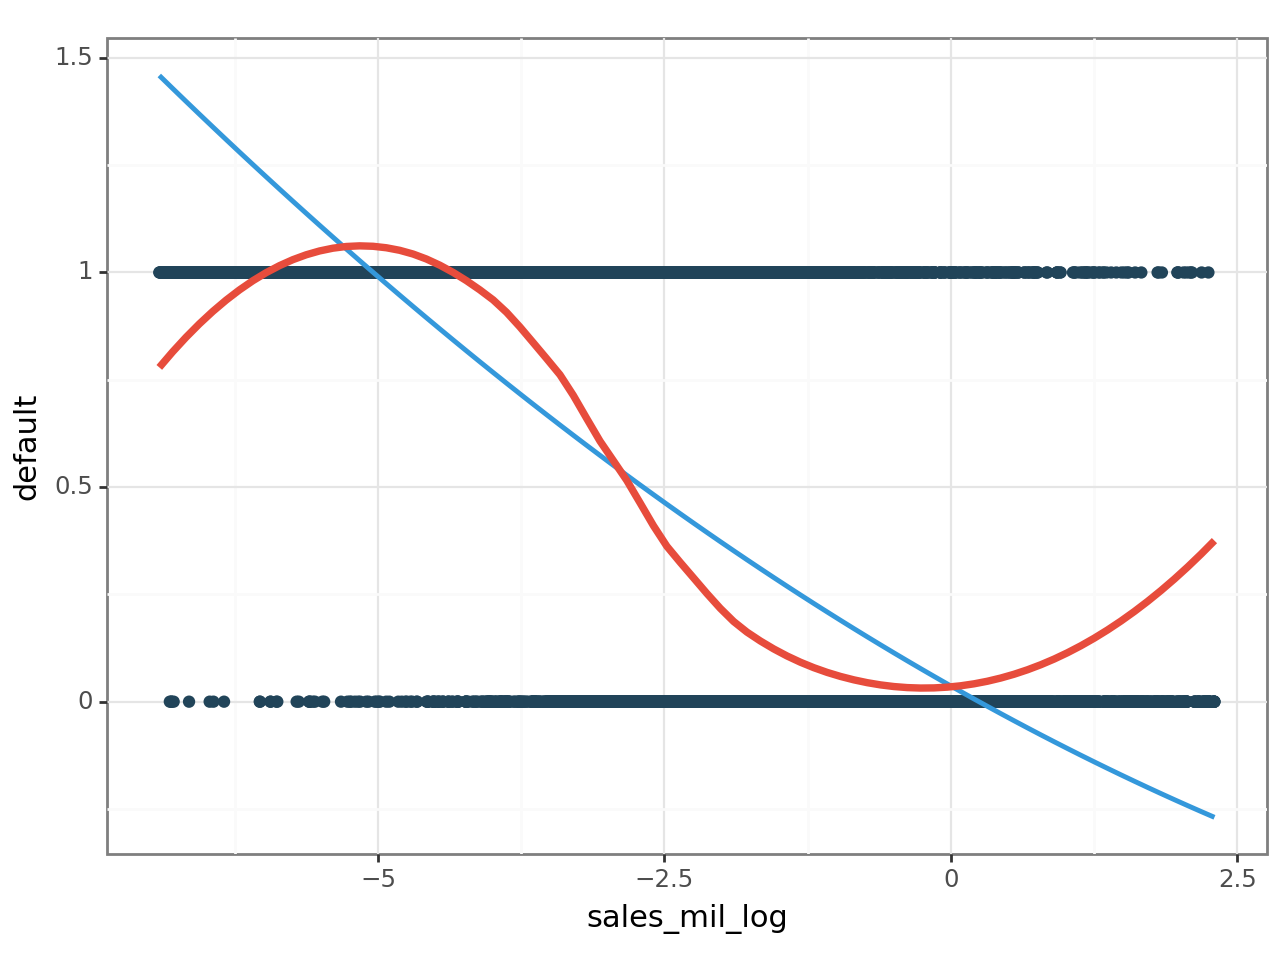

<Figure Size: (640 x 480)>

In [62]:
ggplot(data, aes(x="sales_mil_log", y="default")) + geom_point(
    color="#214459"
) + geom_smooth(
    method="lm", formula="y ~ x + I(x**2)", color="#3498db", se=False  # Assuming #3498db as a placeholder color
) + geom_smooth(
    method="loess", color="#e74c3c", se=False, size=1.5, span=0.9  # Assuming #e74c3c as a placeholder color
) + labs(
    x="sales_mil_log", y="default"
) + theme_bw()


In [63]:
# Performing linear regression: deault on logarithmic sales and squared logarithmic sales
ols_s = smf.ols("default ~ sales_mil_log + sales_mil_log_sq", data=data).fit()
print(ols_s.summary())

                            OLS Regression Results                            
Dep. Variable:                default   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     8128.
Date:                Fri, 23 Feb 2024   Prob (F-statistic):               0.00
Time:                        14:11:20   Log-Likelihood:                -8583.6
No. Observations:               20255   AIC:                         1.717e+04
Df Residuals:                   20252   BIC:                         1.720e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0364      0.006  

### Change in sales

*Note:* Graphs are not in the book!

In [64]:
# lowess
data["d1_sales_mil_log"].describe()

count    20255.000000
mean        -0.003987
std          0.934162
min         -6.889406
25%         -0.086864
50%          0.000000
75%          0.222255
max         11.299683
Name: d1_sales_mil_log, dtype: float64

## 1.7 Model Building

### 1.7.1 Define Variable Sets

#### Main Firm Variables

In [65]:
rawvars = [
    "curr_assets",
    "curr_liab",
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "fixed_assets",
    "inc_bef_tax",
    "intang_assets",
    "inventories",
    "liq_assets",
    "material_exp",
    "personnel_exp",
    "profit_loss_year",
    "sales",
    "share_eq",
    "subscribed_cap",
]

#### Further financial variables

In [66]:
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = [
    "total_assets_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "share_eq_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
    "extra_exp_pl",
    "extra_inc_pl",
    "extra_profit_loss_pl",
    "inc_bef_tax_pl",
    "inventories_pl",
    "material_exp_pl",
    "profit_loss_year_pl",
    "personnel_exp_pl",
]
engvar2 = [
    "extra_profit_loss_pl_quad",
    "inc_bef_tax_pl_quad",
    "profit_loss_year_pl_quad",
    "share_eq_bs_quad",
]

#### Financial Ratios

In [67]:
financial_ratios = [
    "gross_profit_margin",
    "net_profit_margin",
    "return_on_equity",
    "debt_equity_ratio",
    "current_ratio",
    "quick_ratio",
    "return_on_assets"
]

#### Flag Variables

In [68]:
engvar3 = []
for col in data.columns:
    if (
        col.endswith("flag_low")
        or col.endswith("flag_high")
        or col.endswith("flag_error")
        or col.endswith("flag_zero")
    ):
        engvar3.append(col)

#### Growth Variables

In [69]:
d1 = [
    "d1_sales_mil_log_mod",
    "d1_sales_mil_log_mod_sq",
    "flag_low_d1_sales_mil_log",
    "flag_high_d1_sales_mil_log",
]

#### Human capital related variables

In [70]:
hr = [
    "female",
    "ceo_age",
    "flag_high_ceo_age",
    "flag_low_ceo_age",
    "flag_miss_ceo_age",
    "ceo_count",
    "labor_avg_mod",
    "flag_miss_labor_avg",
    "foreign_management",
]

#### Firms history related variables

In [71]:
firm = ["age",
        "age2",
        "new",
        "C(ind2_cat)",
        "C(m_region_loc)",
        "C(urban_m)"]

#### Interactions for logit, LASSO

In [72]:
interactions1 = [
    "C(ind2_cat)*age",
    "C(ind2_cat)*age2",
    "C(ind2_cat)*d1_sales_mil_log_mod",
    "C(ind2_cat)*sales_mil_log",
    "C(ind2_cat)*ceo_age",
    "C(ind2_cat)*foreign_management",
    "C(ind2_cat)*female",
    "C(ind2_cat)*C(urban_m)",
    "C(ind2_cat)*labor_avg_mod",
]
interactions2 = [
    "sales_mil_log*age",
    "sales_mil_log*female",
    "sales_mil_log*profit_loss_year_pl",
    "sales_mil_log*foreign_management",
]

### 1.7.2 Model Setups

#### 1. Simple Logit Models

In [73]:
M1 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "d1_sales_mil_log_mod",
    "profit_loss_year_pl",
    "C(ind2_cat)",
]
M2 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "d1_sales_mil_log_mod",
    "profit_loss_year_pl",
    "fixed_assets_bs",
    "share_eq_bs",
    "curr_liab_bs ",
    "curr_liab_bs_flag_high ",
    "curr_liab_bs_flag_error",
    "age",
    "foreign_management",
    "C(ind2_cat)",
]
M3 = ["sales_mil_log", "sales_mil_log_sq"] + firm + engvar + d1
M4 = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + firm
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + qualityvars
)
M5 = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + firm
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + qualityvars
    + interactions1
    + interactions2
)

#### 2. Logit+LASSO

In [74]:
logit_lasso_vars = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + firm
    + qualityvars
    + interactions1
    + interactions2
)

#### 3. CART and RF (no interactions, no modified features)

In [75]:
rfvars = ["sales_mil", "d1_sales_mil_log"] + rawvars + hr + firm + qualityvars